In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/suicide-watch/Suicide_Detection.csv


In [ ]:
import numpy as np
import pandas as pd
import transformers
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import math
from torch.utils.data import (
    Dataset,
    DataLoader,
    RandomSampler,
    SequentialSampler
)
from transformers import  (
    BertPreTrainedModel,
    RobertaConfig,
    RobertaTokenizerFast
)
from transformers.optimization import (
    AdamW,
    get_linear_schedule_with_warmup
)
from scipy.special import softmax
from torch.nn import CrossEntropyLoss
from sklearn.metrics import (
    confusion_matrix,
    matthews_corrcoef,
    roc_curve,
    auc,
    average_precision_score,
)
from transformers.models.roberta.modeling_roberta import (
    RobertaClassificationHead,
    RobertaConfig,
    RobertaModel,
)
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
class RobertaForClassification(BertPreTrainedModel):

    def __init__(self, config):
        super(RobertaForClassification, self).__init__(config)
        self.num_labels = config.num_labels
        self.roberta = RobertaModel(config)
        self.classifier = RobertaClassificationHead(config)


    def forward(self, input_ids, attention_mask, labels):
        outputs = self.roberta(input_ids,attention_mask=attention_mask)
        sequence_output = outputs[0]
        logits = self.classifier(sequence_output)

        outputs = (logits,) + outputs[2:]

        loss_fct = CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        outputs = (loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

In [ ]:
#Load pre-trained RoBERTa
model_name = "roberta-base"
model = RobertaForSequenceClassification.from_pretrained(model_name)

num_labels = 2
device = torch.device("cuda")

tokenizer_name = model_name

max_seq_length = 128
train_batch_size = 8
test_batch_size = 8
warmup_ratio = 0.06
weight_decay=0.0
gradient_accumulation_steps = 1
num_train_epochs = 1
learning_rate = 1e-05
adam_epsilon = 1e-08

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
config_class = RobertaConfig
model_class = RobertaForClassification
tokenizer_class = RobertaTokenizerFast

config = config_class.from_pretrained(model_name, num_labels=num_labels)

model = model_class.from_pretrained(model_name, config=config)
print('Model=\n',model,'\n')

tokenizer = tokenizer_class.from_pretrained(tokenizer_name, do_lower_case=False)
print('Tokenizer=',tokenizer,'\n')

Some weights of RobertaForClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model=
 RobertaForClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Tokenizer= RobertaTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
} 



In [ ]:
df = pd.read_csv("/kaggle/input/suicide-watch/Suicide_Detection.csv")
df['label'] = df['class'].apply(lambda x: 1 if x.lower() == 'suicide' else 0)
df = df.loc[:, ['text', 'label']]
df.head()

,text,label
0,Ex Wife Threatening SuicideRecently I left my ...,1
1,Am I weird I don't get affected by compliments...,0
2,Finally 2020 is almost over... So I can never ...,0
3,i need helpjust help me im crying so hard,1
4,"I’m so lostHello, my name is Adam (16) and I’v...",1


In [ ]:
train_df, test_df = train_test_split(df, test_size=0.75, random_state=42)

In [ ]:
class MyClassificationDataset(Dataset):

    def __init__(self, data, tokenizer):
        text, labels = data
        self.examples = tokenizer(text=text,text_pair=None,truncation=True,padding="max_length",
                                  max_length=max_seq_length,return_tensors="pt")
        self.labels = torch.tensor(labels, dtype=torch.long)


    def __len__(self):
        return len(self.examples["input_ids"])

    def __getitem__(self, index):
        return {key: self.examples[key][index] for key in self.examples}, self.labels[index]


train_examples = (train_df.iloc[:, 0].astype(str).tolist(), train_df.iloc[:, 1].tolist())
train_dataset = MyClassificationDataset(train_examples,tokenizer)

test_examples = (test_df.iloc[:, 0].astype(str).tolist(), test_df.iloc[:, 1].tolist())
test_dataset = MyClassificationDataset(test_examples,tokenizer)

In [ ]:
def get_inputs_dict(batch):
    inputs = {key: value.squeeze(1).to(device) for key, value in batch[0].items()}
    inputs["labels"] = batch[1].to(device)
    return inputs

train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset,sampler=train_sampler,batch_size=train_batch_size)

test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=test_batch_size)

In [ ]:
#Extract a batch as sanity-check
batch = get_inputs_dict(next(iter(train_dataloader)))
input_ids = batch['input_ids'].to(device)
attention_mask = batch['attention_mask'].to(device)
labels = batch['labels'].to(device)

print(batch)

{'input_ids': tensor([[    0,  5521,  2459,  ...,     1,     1,     1],
        [    0,   574,  1264,  ...,     1,     1,     1],
        [    0,  2709,  1774,  ...,    89,    74,     2],
        ...,
        [    0, 32361,  3662,  ...,  1349,   141,     2],
        [    0,   100,  4157,  ...,  7527,     9,     2],
        [    0, 43087,  3663,  ...,    69,   116,     2]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]], device='cuda:0'), 'labels': tensor([0, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')}


In [ ]:
t_total = len(train_dataloader) // gradient_accumulation_steps * num_train_epochs
optimizer_grouped_parameters = []
custom_parameter_names = set()
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters.extend(
    [
        {
            "params": [
                p
                for n, p in model.named_parameters()
                if n not in custom_parameter_names and not any(nd in n for nd in no_decay)
            ],
            "weight_decay": weight_decay,
        },
        {
            "params": [
                p
                for n, p in model.named_parameters()
                if n not in custom_parameter_names and any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.0,
        },
    ]
)

warmup_steps = math.ceil(t_total * warmup_ratio)
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def compute_metrics(preds, model_outputs, labels, eval_examples=None, multi_label=False):
    assert len(preds) == len(labels)
    mismatched = labels != preds
    wrong = [i for (i, v) in zip(eval_examples, mismatched) if v.any()]
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds, labels=[0, 1]).ravel()
    scores = np.array([softmax(element)[1] for element in model_outputs])
    fpr, tpr, thresholds = roc_curve(labels, scores)
    auroc = auc(fpr, tpr)
    auprc = average_precision_score(labels, scores)
    return (
        {
            **{"mcc": mcc, "tp": tp, "tn": tn, "fp": fp, "fn": fn, "auroc": auroc, "auprc": auprc},
        },
        wrong,
    )

def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

def print_confusion_matrix(result):
    cm = [[result['tn'], result['fp']],
          [result['fn'], result['tp']]]
    plot_confusion_matrix(cm)

In [ ]:
device = torch.device("cuda")
model.cuda()

RobertaForClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

Evaluating Epoch 1/1: 100%|██████████| 14505/14505 [08:13<00:00, 29.39batch/s, Eval Loss=0.0193]


Epoch 0 Training avg loss: 0.04880837530345795
Epoch 0 Testing  avg loss: 0.019270257074179616
{'mcc': 0.9864012575263111, 'tp': 57517, 'tn': 57731, 'fp': 368, 'fn': 421, 'auroc': 0.9997174419248774, 'auprc': 0.9997387341383221}


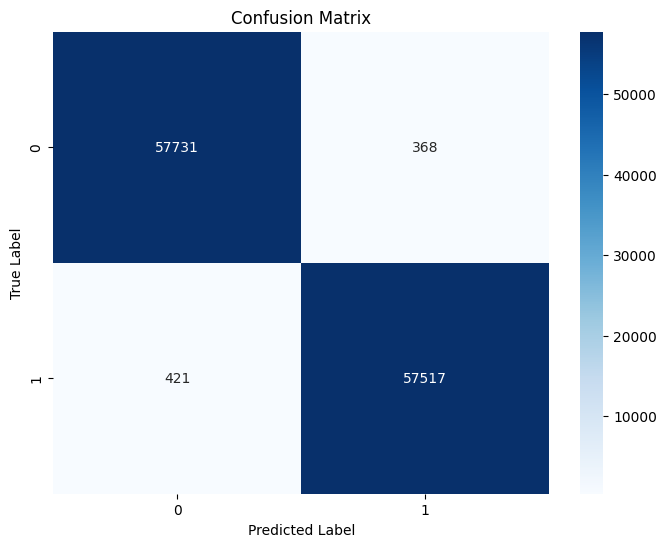

---------------------------------------------------



In [ ]:
from tqdm import tqdm

# Training loop
for epoch in range(num_train_epochs):
    model.train()
    epoch_loss = []
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_train_epochs}", unit="batch")

    for batch in progress_bar:
        batch = get_inputs_dict(batch)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optimizer.step()
        scheduler.step()
        model.zero_grad()
        epoch_loss.append(loss.item())

        # Update progress bar description with current loss
        progress_bar.set_postfix({"Loss": loss.item()})

    # Evaluate model with test dataset
    eval_loss = 0.0
    nb_eval_steps = 0
    progress_bar = tqdm(test_dataloader, desc=f"Evaluating Epoch {epoch+1}/{num_train_epochs}", unit="batch")
    preds = np.empty((len(test_dataset), num_labels))
    out_label_ids = np.empty((len(test_dataset)))
    model.eval()

    for i, test_batch in enumerate(progress_bar):
        with torch.no_grad():
            test_batch = get_inputs_dict(test_batch)
            input_ids = test_batch['input_ids'].to(device)
            attention_mask = test_batch['attention_mask'].to(device)
            labels = test_batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            tmp_eval_loss, logits = outputs[:2]
            eval_loss += tmp_eval_loss.item()

        nb_eval_steps += 1
        start_index = test_batch_size * i
        end_index = start_index + test_batch_size if i != (len(test_dataloader) - 1) else len(test_dataset)
        preds[start_index:end_index] = logits.detach().cpu().numpy()
        out_label_ids[start_index:end_index] = test_batch["labels"].detach().cpu().numpy()

        # Update progress bar description with current evaluation loss
        progress_bar.set_postfix({"Eval Loss": eval_loss / nb_eval_steps})

    # Calculate evaluation loss and metrics
    eval_loss = eval_loss / nb_eval_steps
    model_outputs = preds
    preds = np.argmax(preds, axis=1)
    result, wrong = compute_metrics(preds, model_outputs, out_label_ids, test_examples)

    # Print epoch training and evaluation results
    print(f'Epoch {epoch} Training avg loss: {np.mean(epoch_loss)}')
    print(f'Epoch {epoch} Testing  avg loss: {eval_loss}')
    print(result)
    print_confusion_matrix(result)
    print('---------------------------------------------------\n')

In [ ]:
model.save_pretrained("finetuned_classifer")

import shutil

shutil.make_archive("finetuned_classifer", "zip", "finetuned_classifer")

'/kaggle/working/finetuned_classifer.zip'

# ***Inference***

In [ ]:
from transformers import RobertaForSequenceClassification
from transformers import RobertaTokenizer

# Load the fine-tuned model
model = RobertaForSequenceClassification.from_pretrained("/kaggle/working/finetuned_classifer")
# Load the tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [ ]:
# Tokenize input text
input_text = "i want to kill myself but i am very very happy today."
encoded_input = tokenizer(input_text, return_tensors="pt")

In [ ]:
# Perform inference
with torch.no_grad():
    outputs = model(**encoded_input)

predictions = outputs.logits.argmax(dim=1)

In [ ]:
if predictions == 1:
    print("The model predicts that the text is depressed.")
else:
    print("The model predicts that the text is not depressed.")

The model predicts that the text is not depressed.
